<a href="https://colab.research.google.com/github/blufzzz/Introspective-Neural-Networks/blob/master/training_textures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [1]:
cd ./gdrive/My\ Drive/Colab Notebooks/Introspective-Neural-Networks-master

/content/gdrive/My Drive/Colab Notebooks/Introspective-Neural-Networks-master


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from torchvision.models.resnet import ResNet, BasicBlock, resnet18
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
import os
import numpy as np
import PIL.Image as Image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomResizedCrop, RandomCrop
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.cuda import set_device
# set_device(gpu_id)
# gpu_id = 2;
from tqdm import tnrange, tqdm_notebook

from synthesis import Synthesis
from utils import MnistDataset, get_data_loaders, calculate_metric, print_scores
from models import MnistResNet

In [0]:
def train(model, train_loader, val_loader, epochs=1, alpha=0.9):

    start_ts = time.time()

    losses = []
    loss_function = nn.CrossEntropyLoss()
    #optimizer = optim.Adadelta(model.parameters())
    optimizer = optim.Adam(model.parameters(), amsgrad=True)
    #optimizer = optim.SGD(model.parameters(), lr=1e-2);

    batches = len(train_loader)
    val_batches = len(val_loader)

    # training loop + eval loop
    for epoch in range(epochs):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()

        for i, data in progress:
            X, y = data[0].cuda(), data[1].cuda().squeeze(-1).long()
            
            model.zero_grad()
            outputs = model.forward(X)
            loss = loss_function(outputs, y.long());

            loss.backward()
            optimizer.step()
            progress.set_description("Loss: {:.4f}".format(loss.item()))

        torch.cuda.empty_cache()

        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].cuda(), data[1].cuda()
                
                outputs = model.forward(X)
                val_losses += loss_function(outputs, y.long())

                predicted_classes = torch.argmax(outputs, 1).detach()

                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.detach().cpu(), predicted_classes.cpu())
                    )


        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches)
    pass

In [0]:
class TextureResNet(torch.nn.Module):
        
    def __init__(self, net):
        super(TextureResNet, self).__init__()
        
        self.net = net
        self.net.fc = torch.nn.Linear(512, 2);
        self.softmax = nn.Softmax()
        self.X = torch.nn.Parameter(torch.empty((1, 3, 256, 256)).normal_(mean=0, std=0.3));
        self.X.requires_grad = False;
        
    def forward(self, x):

        return  self.softmax(self.net(x))
    
    def to_synth(self):
        return self.net(self.X)
      
      

In [0]:
class TextureDataset(torch.utils.data.Dataset):
  
      def __init__(self, root_dir = './static_textures', texture_names = ['clover'], train_size = 100, training=True):
          self.root_dir = root_dir
          self.train_size = train_size
          self.imgs = [];
          self.labels = [];
          self.textures = []
          
          for texture_name in texture_names:
              path = os.path.join(root_dir, texture_name + '.jpg')
              img = Image.open(path)
              
              self.textures.append(img)
              
              for i in range(train_size):
                  
                  img = RandomCrop((64,64), padding_mode='reflect')(img)
                  img = Resize((256,256))(img)
                  img_tensor = ToTensor()(img)
                  self.imgs.append(img_tensor.unsqueeze(0))
                  self.labels.append(torch.tensor(0))

        
      def __getitem__(self, idx):

          x = self.imgs[idx];
          y = self.labels[idx];
        
          return x, y
        
      def add_artificial(self, X):
          for i in range(X.shape[0]):
              self.imgs.append(X[i].detach().cpu());
              self.labels.append(torch.tensor(1));
          pass
        
        
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
    img = img.astype('float')

    return  img          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(256, 256, 3) tensor([[0.4442, 0.5558]], grad_fn=<SoftmaxBackward>)


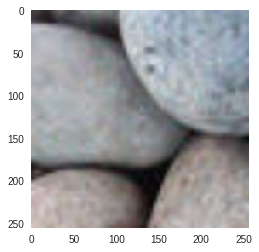

In [141]:
model = TextureResNet(resnet18())
texture_dataset = TextureDataset(texture_names = ['stone'])

im = texture_dataset[0][0]
img = deprocess(im)
print(img.shape, model.forward(im))
plt.imshow(img)
plt.grid(False)

In [142]:
l = 200;
tmax = 10;
dataset = texture_dataset

for t in tqdm_notebook(range(tmax)):
    model = TextureResNet(resnet18()).cuda();
    
    # add l pseudo-negative
    s = Synthesis(init_std=0.3)
    for i in range(l):
        aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
        
        # normalize
        aug -= aug.min();
        aug /= aug.max();

        dataset.add_artificial(aug);
        
    # train    
    train(model, train_loader, val_loader, alpha=0.1);    

NameError: ignored

# Visualize pseudo-negative

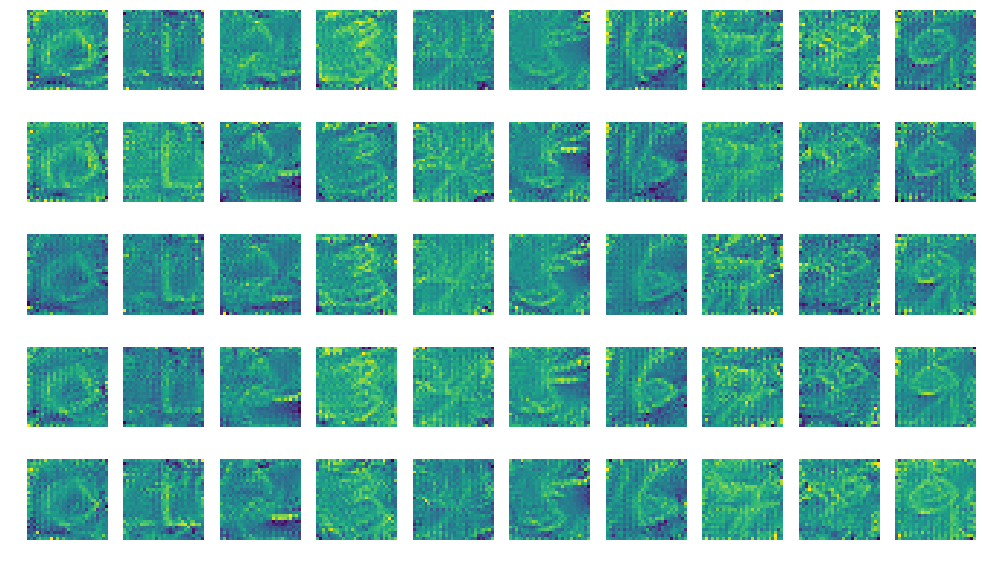

In [0]:
fig,ax = plt.subplots(nrows=5, ncols=10, figsize=(17,10));
for j in range(5):
    s = Synthesis(init_std=0.3)
    aug = s.sample(model, num_iter=50, learning_rate=1e-1, add_noise=True);
    for i in range(aug.shape[0]):
            aug[i,...] -= aug[i, ...].min();
            aug[i, ...] /= aug[i, ...].max();
    for i in range(10):
        ax[j][i].imshow(aug[i,0,...].cpu());
        ax[j][i].axis('off');